In [2]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Pytorch packages
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skorch import NeuralNetClassifier

# Set the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)

# Set the seed for torch
torch.manual_seed(189898)

cuda


In [16]:
# Import the Data
mnist = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Initialize training set
X_train = mnist.data
y_train = mnist.targets

# Initialize test set
X_test = test_dataset.data
y_test = test_dataset.targets

# Normalize
X_train = X_train.float() / 255.0
X_test = X_test.float() / 255.0

# Reshape to have 4 channels
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

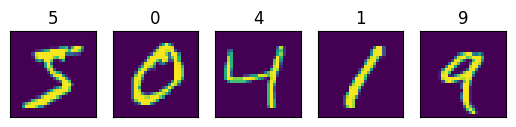

In [17]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row"""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

plot_example(X_train, y_train)

### Part 1
10 Pts: Design and train a CNN with at least two convolutional layers, each followed by a maxpooling layer, for the MNIST dataset. Use dropout and L2 regularization on the weights when training the network. Use standard stochastic gradient descent in this part of the problem. Use grid search to tune hyper-parameters. Include your code. Record your final test accuracy and give a description on how you designed the network and briefly on how you made your design choices (e.g., numbers of layers, initialization strategies, parameter tuning, adaptive learning rate or not, momentum or not, etc.). To get full credit, you will need to get an accuracy of at least 98%.

In [13]:
# Build the CNN
class CNN(nn.Module):
    def __init__(self, dropout=0.4, c1=16, c2=32, l1=128):
        super(CNN, self).__init__()
        
        # Convolutional and Pooling Layers
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Linear Layers and Dropout for Classification
        self. classification = nn.Sequential(
            nn.Linear(c2 * 7 * 7, l1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(l1, 10)
        )
        
    def forward(self, x):
        x = self.convolution(x)
        x = x.view(x.size(0), -1)
        return self.classification(x)

In [14]:
# Add L1 regularization

class RegularizedNetwork(NeuralNetClassifier):
    def __init__(self, *args, lambda1=0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
    
    '''
    *** In submission PDF, explain what this method is doing ***
    '''
    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss = super().get_loss(y_pred, y_true, x=X, training=training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [15]:
cnn = CNN()
print(cnn)

CNN()


In [16]:
if device != "cuda":
    print("Warning: not using cuda, training performance will be impacted")
    print(f"Current device is {device}")

In [17]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__<name of your parameter> = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNetwork(module = CNN, 
                     max_epochs = ...,
                     criterion = torch.nn.NLLLoss, 
                     optimizer = ...,
                     lr = ..., 
                     lambda1 = 0,
                     module__dropout = ...,
                     optimizer__weight_decay = ...,
                     device = device)

In [18]:
# Train the network
cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Observe the correlation between loss and validation accuracy
'''

TypeError: 'ellipsis' object is not callable

In [ ]:
# Predict for the test set and get accuracy
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
# Do Grid search to get above 98% accuracy
'''
Step -- Define a grid with some parameters you believe may give good performance (learning rate, regularization parameter, number of nodes)
'''
# can use cnn.get_params().keys() to get all tuneable parameters
tuneable = cnn.get_params().keys()

# Define the grid and do the search
grid = {
    'lr': [0.001, 0.01, 0.1, 1],
}
gs = GridSearchCV(cnn, grid, refit=True, cv=5, scoring='accuracy')

# Fit the best model and report best score and parameters
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

### Part 2
10 Pts: Starting with the network you designed in the previous problem, replace L2 regularization with L1 regularization and tune the regularization parameter as well as the learning rate. Explain what the get loss method is doing in the RegularizedNet class. Use two initialization strategies: 
1) initialize with the weights obtained using L2 regularization and 
2) initialize randomly. 
 
 Which initialization strategy worked the best? Based on your results, which regularization worked best on this data?

### Part 3
10 Pts: Start with the best network you have obtained so far. Keeping the same hyperparameters of this network, you will now apply several different optimizers to retrain the network. 
(a) Use the following approaches to optimization: 1) standard SGD; 2) SGD with momentum; 3) AdaGrad; 4) Adam. Tune any of the associated parameters including the global learning rate using the validation accuracy. Report the final parameters selected in each case, and the final test accuracy in each case. Provide two plots with the results from all four approaches: 1) the training cost vs the number of epochs and 2) the validation accuracy vs the number of epochs. Which optimization approach seems to be working the best and why?
(b) Pick one of the optimization approaches above. Using the same network, apply batch normalization to each of the hidden layers and retune the (global) learning rate using the validation accuracy. Report the new learning rate and the final test accuracy. Does batch normalization seem to help in this case?